In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.spatial.distance import cdist

In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/blaubach/chimes_CGD-myLLFork/dissimilarity_clustering/training_set_reduction


In [3]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

# Define file paths with cwd appended
file_path_2b = os.path.join(cwd, "../dft_pds/2b_all_pd")
file_path_3b = os.path.join(cwd, "../dft_pds/3b_all_pd")
file_path_4b = os.path.join(cwd, "../dft_pds/4b_all_pd")
file_path_labels = os.path.join(cwd, "../dft_pds/labels_pd")
file_path_natoms = os.path.join(cwd, "../test_notebooks/energies_per_atom.txt")

# Open pickle files with the updated file paths
with open(file_path_2b, 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open(file_path_3b, 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open(file_path_4b, 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open(file_path_labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

natom_list = []

# Open the text file for reading
with open(file_path_natoms, 'r') as file:

    # Read the contents of the file
    lines = file.readlines()[1:]

    # Iterate through each line
    for line in lines:

        # Split the line into words
        words = line.split()
        natoms = line.split("|")[1].strip()

        # Extract the last word, assuming it's a number
        last_number = float(words[-1])
        if words[0][-1] == 'z':
            print(words[0])
            continue
        natom_list.append(natoms)

natom_list = np.array(natom_list[:-10])

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1, all_array.shape[2])
print(np.shape(all_array))
df_fingerprints = pd.DataFrame(all_array)

# Define the column labels for each set of columns
column_labels_2b = [f'2B_{i}' for i in range(60)]
column_labels_3b = [f'3B_{i}' for i in range(60)]
column_labels_4b = [f'4B_{i}' for i in range(60)]

# Assign the column labels to the DataFrame
column_labels = column_labels_2b + column_labels_3b + column_labels_4b
df_fingerprints.columns = column_labels

# Add a new column "labels" to the DataFrame and assign the new vector to it
df_fingerprints['labels'] = labels

# Calculate the row-wise mean using `mean(axis=1)`
row_avg = df_fingerprints.mean(axis=1)

# Append the calculated row-wise mean as a new column named "Pavg"
df_fingerprints['Pavg'] = row_avg

# Calculate the row-wise standard deviation using `std(axis=1)`
row_std = df_fingerprints.std(axis=1)

# Append the calculated row-wise standard deviation as a new column named "Pstd"
df_fingerprints['Pstd'] = row_std

# Append Natoms to Dataframe
df_fingerprints['Natoms'] = natom_list

df_fingerprints.head()


/Users/blaubach/chimes_CGD-myLLFork/dissimilarity_clustering/training_set_reduction
training_data_#0000.xyz
training_data_#0050.xyz
training_data_#0055.xyz
training_data_#0060.xyz
training_data_#0075.xyz
training_data_#0080.xyz
training_data_#0110.xyz
(300, 180)


,2B_0,2B_1,2B_2,2B_3,2B_4,2B_5,2B_6,2B_7,2B_8,2B_9,...,4B_54,4B_55,4B_56,4B_57,4B_58,4B_59,labels,Pavg,Pstd,Natoms
0,0.151940,0.079974,0.039987,0.134957,0.000000,0.039987,0.000000,0.059981,0.000000,0.064979,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.025764,216
1,0.151838,0.089548,0.030670,0.107863,0.026939,0.039628,0.000530,0.059527,0.008709,0.053400,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.024411,216
2,0.152059,0.091794,0.027968,0.104630,0.029103,0.039305,0.001128,0.058054,0.005966,0.057973,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.024316,216
3,0.113888,0.093885,0.074372,0.063481,0.048075,0.037675,0.033869,0.031662,0.025958,0.021373,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016348,0.020050,216
4,0.118745,0.094125,0.073008,0.061039,0.048168,0.036493,0.032401,0.030655,0.026413,0.021867,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016344,0.020228,216


In [6]:
# Initialize the minimum occurrence count required
from scipy.stats.stats import pearsonr  
from tqdm import tqdm

def compute_pij(phi1, phi2):

    # Compute statistics for training set
    phi1_fingerprint = phi1.iloc[:-4].fillna(0)
    phi1_fingerprint=phi1_fingerprint.to_numpy()

    # Compute statistics for phi2
    phi2_fingerprint = phi2.iloc[:-4].fillna(0)
    phi2_fingerprint=phi2_fingerprint.to_numpy()

    correlation = pearsonr(phi1_fingerprint, phi2_fingerprint)

    return correlation.statistic

n = int(len(df_fingerprints))
pij_matrix = np.zeros((n,n))

# Iterate over each pair of rows
for i in tqdm(range(n)):
    for j in range(n):
        # Compute the scalar using compute_pij function
        pij = compute_pij(df_fingerprints.iloc[i], df_fingerprints.iloc[j])
        # Assign the scalar to the corresponding index in zeros_array
        pij_matrix[i, j] = float(pij)

# np.fill_diagonal(pij_matrix, -np.inf)
pij_matrix = np.nan_to_num(pij_matrix, nan=0)
print(pij_matrix)

/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_39490/1164492384.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


100%|██████████| 300/300 [00:42<00:00,  6.98it/s]

[[1.         0.97763552 0.97671469 ... 0.74117087 0.72856461 0.73602541]
 [0.97763552 1.         0.99904957 ... 0.78139546 0.76848581 0.77641084]
 [0.97671469 0.99904957 1.         ... 0.7835449  0.7706111  0.77859554]
 ...
 [0.74117087 0.78139546 0.7835449  ... 1.         0.99827865 0.99967785]
 [0.72856461 0.76848581 0.7706111  ... 0.99827865 1.         0.99907111]
 [0.73602541 0.77641084 0.77859554 ... 0.99967785 0.99907111 1.        ]]


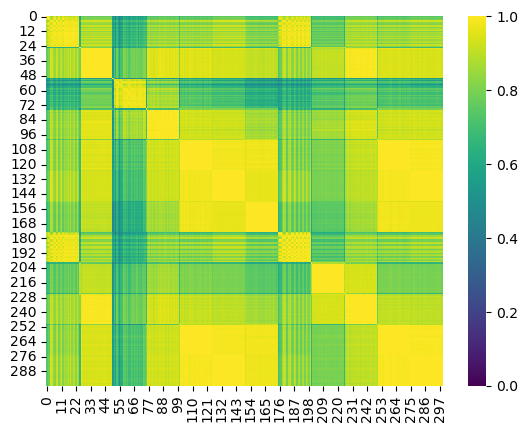

In [7]:
import seaborn as sns

# Create a heatmap with Seaborn
sns.heatmap(pij_matrix, cmap='viridis', vmin=0)

# Display the heatmap
plt.show()

0
55
50
75
100
250
225
175
52
200
25
56
176
54
174
177
57
164
51
202
1
62
162
181
69
172
63
2
203
60
189
161
72
192
169
182
210
71
195
65
173
204
150
67
185
186
220
53
163
157
66
198
201
167
70
209
159
12
68
9
207
6
61
155
160
215
59
153
64
22
205
170
197
217
74
24
154
219
58
152
216
5
73
206
165
178
214
156
17
224
19
212
151
223
190
222
158
213
166
168
208
193
218
171
14
211
221
15
188
194
125
10
13
183
298
191
252
268
196
283
118
20
270
199
264
107
256
187
112
280
21
254
272
16
104
275
253
180
269
226
292
78
179
251
7
281
229
261
184
81
265
18
293
8
273
106
76
92
237
113
83
11
115
23
122
263
247
4
289
95
276
234
79
258
244
121
287
84
3
102
299
232
90
114
290
231
93
109
97
130
230
262
240
284
124
82
241
271
136
242
99
257
129
243
80
288
233
236
146
246
291
239
128
96
147
238
149
91
140
249
259
248
134
227
111
235
255
87
137
119
145
94
266
228
138
245
142
148
88
279
285
116
127
294
126
86
297
141
132
139
85
135
260
131
77
103
89
295
143
98
296
108
105
144
267
101
282
274
110
133
277
31

Text(0.5, 1.0, 'Training Set Optimization with ChIMES Dissimilarity Matrix')

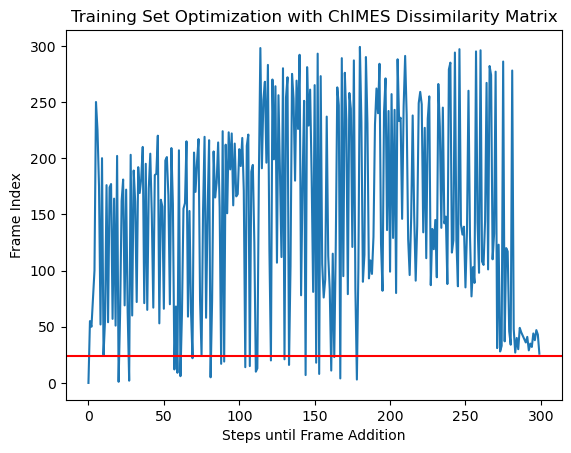

In [11]:
def calculate_min_pij(frame_pij_matrix):

    if frame_pij_matrix.ndim == 1:
        frame_pij_matrix = frame_pij_matrix.reshape(1, -1)  # Reshape into a single row
        max_index = np.argmax(first_column)
    else:

        # Sum each row
        row_sums = np.sum(frame_pij_matrix, axis=1)

        # Find the index of the row with the minimum sum
        max_index = np.argmin(row_sums)
    print(max_index)

    return max_index

def update_datasets(training_frames, available_frames, pij_matrix_copy, training_pij, max_index):

    pij_matrix_copy[max_index, :] = np.inf
    column_n = pij_matrix_copy[:, max_index-1:max_index]
    training_pij = np.hstack((training_pij, column_n))

    row_to_append = available_frames.loc[max_index]
    training_frames = pd.concat([training_frames, row_to_append], axis=1, join="inner")

    return training_frames, available_frames, pij_matrix_copy, training_pij


starting_frame = 0
training_set = pd.DataFrame()
training_set = pd.concat([training_set, df_fingerprints.iloc[starting_frame]])
pij_matrix_copy = copy.copy(pij_matrix)

# Modify Pij matrix
pij_matrix_copy[starting_frame, :] = np.inf
training_pij_copy = copy.copy(pij_matrix_copy[:, :1])

# Extract the first column
first_column = pij_matrix_copy[:, starting_frame]
max_index = calculate_min_pij(first_column)

frame_list = [0]
for i in range(299):
    training_set, df_fingerprints, pij_matrix_copy, training_pij_copy = update_datasets(training_set, df_fingerprints, pij_matrix_copy, training_pij_copy, max_index)
    max_index = calculate_min_pij(training_pij_copy)
    frame_list.append(max_index)
plt.plot(frame_list)
plt.axhline(y=24, color='red')
plt.xlabel("Steps until Frame Addition")
plt.ylabel("Frame Index")
plt.title("Training Set Optimization with ChIMES Dissimilarity Matrix")
